In [10]:
import pandas as pd
import matplotlib.pyplot as plt

BASE_PATH = "C:/Users/99818854/Projetos/GitRep/Simulacoes"

In [3]:
# Carrega bases para processamento
sales = pd.read_excel(f"{BASE_PATH}/data/ecommerce.xlsx", sheet_name="Vendas").sort_values("Data", ascending=True)
customers = pd.read_csv(f"{BASE_PATH}/data/ml/ecommerce - orange - perfil de clientes.csv")

# Organiza perfil de clientes em árvore
customer_groups = {}
for i in range(0, len(customers)):
    customer_groups[customers["Cliente"].values[i]] = customers["Grupo"].values[i]

## O que precisamos saber?

- Qual a venda total em cada categoria?
- Qual a venda total de cada produto?
- Quais os 10 clientes que mais gastam? Qual o grupo de cada um?
- Qual o aumento de venda durante uma campanha de marketing?

In [ ]:
categories = set(sales["Categoria"].values)

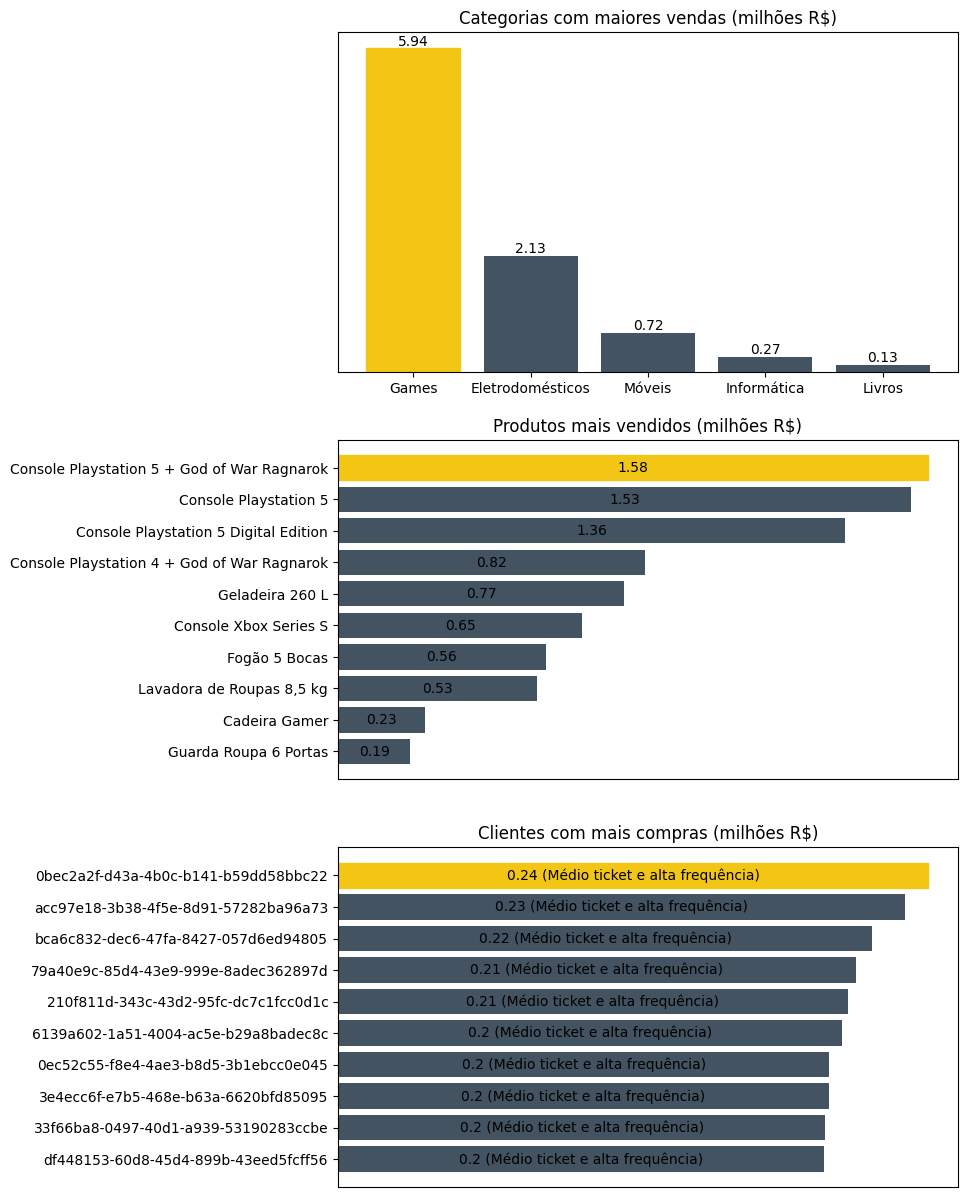

In [63]:
fig, ax = plt.subplots(3, 1, figsize=(8, 15))
group = sales.groupby("Categoria")["Preço de Venda (R$)"].sum().sort_values(ascending=False)
chart = ax[0].bar(group.index, group.values, color="#435362")
ax[0].bar_label(chart, labels=[round(v / 1000000, 2) for v in group.values])
ax[0].set_title("Categorias com maiores vendas (milhões R$)")
ax[0].axes.yaxis.set_visible(False)
chart[0].set_color("#f3c615")

group = sales.groupby("Produto")["Preço de Venda (R$)"].sum().nlargest(n=10)
chart = ax[1].barh(group.index, group.values, color="#435362")
ax[1].bar_label(chart, labels=[round(v / 1000000, 2) for v in group.values], label_type="center")
ax[1].set_title("Produtos mais vendidos (milhões R$)")
ax[1].invert_yaxis()
ax[1].axes.xaxis.set_visible(False)
chart[0].set_color("#f3c615")

group = sales.groupby("Cliente")["Preço de Venda (R$)"].sum().nlargest(n=10)
chart = ax[2].barh(group.index, group.values, color="#435362")
ax[2].bar_label(chart, labels=[f"{round(group.values[i] / 1000000, 2)} ({customer_groups[group.index[i]]})" for i in range(0, len(group))], label_type="center")
ax[2].set_title("Clientes com mais compras (milhões R$)")
ax[2].invert_yaxis()
ax[2].axes.xaxis.set_visible(False)
chart[0].set_color("#f3c615")

plt.show()